In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


In [2]:
def generate_index(X): 
    rweights = np.random.uniform(0,1,X.shape[1])
    rweights = rweights/np.sum(rweights)

    portfolio = np.dot(X,rweights)

    return portfolio, rweights 

In [3]:
import statsmodels.api as sm

def ols_regression(X, y):
    # Add a constant column to the X matrix
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()

    # Return the fitted values
    return results


In [4]:
from sklearn.linear_model import Ridge

def ridge_regression(X, y, alpha):
    # Create a Ridge regression model
    model = Ridge(alpha=alpha)

    # Fit the model to the data
    model.fit(X, y)

    # Predict the target variable
    y_pred = model.predict(X)

    return y_pred

In [5]:
def compute_mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [6]:
def compute_negative_drawdown(returns):
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - peak
    negative_drawdown = np.min(drawdown)
    return negative_drawdown

### Tried autoencoder with cross validation on how many non communal stocks do we pick (not working) 


In [7]:
from sklearn.model_selection import TimeSeriesSplit

def autoencoder_cross_val(X, Y):
    # Prepare the data
    X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
    Y_train, Y_test = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]

    X_train_normalized = (X_train - X_train.mean()) / X_train.std()
    X_test_normalized = (X_test - X_test.mean()) / X_test.std()

    l = len(X_train_normalized[1])
    Nb_most_comm = l/10 #take care of the trend 
    folds = 5 # 5 different numbers of least communal for cross validation  
    validation_itr_train = TimeSeriesSplit(n_splits=folds).split(X_train_normalized)
    validation_itr_test = TimeSeriesSplit(n_splits=folds).split(X_test_normalized)
    score = float('inf')

    for i, (train_idx, test_idx) in enumerate(zip(validation_itr_train, validation_itr_test)):
        print(len(X_train_normalized))
        print(len(X_test_normalized))
        print(train_idx)
        print(test_idx)

        # Build the autoencoder model

        input_dim = X_train_normalized[train_idx].shape[1]

        input_layer = layers.Input(shape=(input_dim,))
        encoder = layers.Dense(30, activation='relu')(input_layer)
        decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

        autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

        # Compile and train the autoencoder
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_train_normalized[train_idx],X_train_normalized[train_idx], epochs=10, batch_size=32, validation_data=(X_test_normalized[test_idx],X_test_normalized[test_idx]))

        print(len(X_train_normalized))
        print(len(X_train_normalized))
        print(train_idx)
        print(test_idx)

        # Extract the decoded features
        decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
        decoded_features_test = decoder_model.predict(X_test_normalized)
        decod_error = abs(decoded_features_test-X_test_normalized)

        sum_of_squares = np.sum(decod_error**2, axis=0)
        print(sum_of_squares.shape)

        #CROSS VALIDATION PARAMETER 
        Nb_least_comm =  (i+1)*l/10  
        Nb_most_comm = int(Nb_most_comm)
        Nb_least_comm = int(Nb_least_comm)

        # Get the indices of the features with the smallest average decoding error
        most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

        # Get the indices of the features with the highest average decoding error
        least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

        selected_features = np.concatenate((most_comm_indices, least_comm_indices))
        #print(selected_features)
        selected_X_test_normalized = X_test_normalized[selected_features,test_idx]

        # De-normalize the selected_X_test_normalized
        selected_X_test_denormalized = (selected_X_test_normalized * X_train.std()) + X_train.mean()

        # Run OLS regression
        predicted_values = ols_regression(selected_X_test_denormalized.T, Y_test[test])

        #CROSS VALIDATION 

        # Compute MSE
        mse = compute_mse(predicted_values, Y_test)
 
        # Compute negative drawdown
        negative_drawdown = compute_negative_drawdown(predicted_values)

        #SELECTION CRITERIA, MUST IMPOSE PENALTY ON NUMBER OF SELCTED FEATURES (MIGHT WANT TO ACCOUNT FOR FIXED T COSTS HERE ??)

        score_n = (mse+negative_drawdown+(mse+negative_drawdown)*(Nb_least_comm/(Nb_least_comm + Nb_most_comm)))/3

        # Check if the current score is smaller than the previous iteration score 
        if score_n < score:
            score = score_n
            Nb_least_comm_val = Nb_least_comm

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))
    selected_X_test_normalized = X_test_normalized[selected_features, :]

    # De-normalize the selected_X_test_normalized
    selected_X_test_denormalized = (selected_X_test_normalized * X_train.std()) + X_train.mean()

    # Print the selected features and their shape
    print("Nb_least_comm_val:", Nb_least_comm_val)
    print("Nb_most_comm:", Nb_most_comm)
    print("Shape of selected_X_test_denormalized:", selected_X_test_denormalized.shape)

    # Return the de-normalized array
    return selected_X_test_denormalized, Nb_most_comm, Nb_least_comm_val

### Simple autoencoder

In [38]:
from tensorflow.keras import regularizers

def sparse_autoencoder(X_train, X_test):
    # Prepare the data
    l = len(X_train.values[1])
    
    Nb_most_comm = 5
    Nb_least_comm =  15

    # Build the autoencoder model
    input_dim = X_train.shape[1]
    #print(input_dim)
    hidden_dim = 5

    input_layer = layers.Input(shape=(input_dim,))
    normalization = layers.BatchNormalization(axis = 1)(input_layer)
    encoder = layers.Dense(hidden_dim, activation='relu')(normalization)
    decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

    # Compile and train the autoencoder
    #print(X_train.shape)
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(X_train, X_train, epochs=30, batch_size=64, validation_data=(X_test, X_test))

    # Extract the decoded features
    decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
    decoded_features_test = decoder_model.predict(X_test)
    decod_error = abs(decoded_features_test - X_test)

    #print(decod_error.mean(axis=0))
    mean_values = X_test.mean(axis=0)
    percentage_error = (decod_error.mean(axis=0) / mean_values) * 100
    #print(percentage_error)
    
    sum_of_squares = np.sum(decod_error**2, axis=0)

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = X_test.columns[np.argsort(sum_of_squares)[:Nb_most_comm]]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = X_test.columns[np.argsort(sum_of_squares)[-Nb_least_comm:]]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))
    selected_X_test = X_test[selected_features]
    selected_X_train = X_train[selected_features]

    print("Number of features in selected X_test:", selected_X_test.shape)
    print("Number of features in selected X_train:", selected_X_train.shape)
    print("Most communal features:", len(most_comm_indices))
    print("Least communal features:", len(least_comm_indices))

    # Return the de-normalized arrays
    return selected_X_test, selected_X_train, Nb_most_comm, Nb_least_comm, history


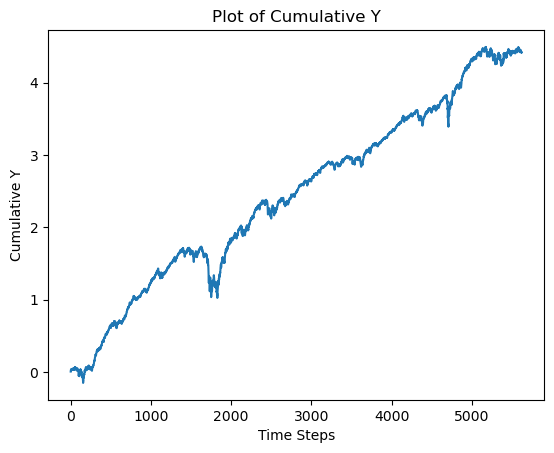

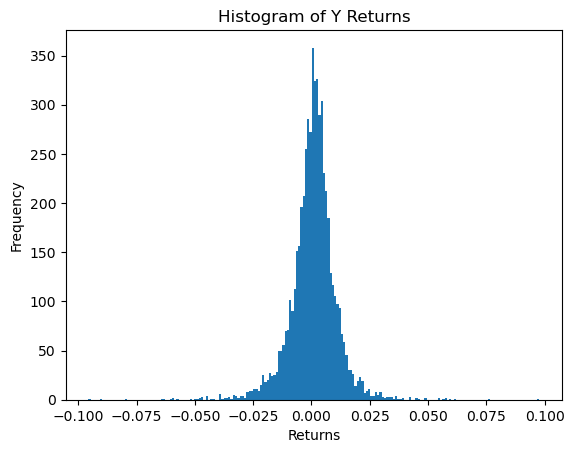

In [9]:
returns = pd.read_csv('Index_Replication_Data/X_USD.csv', index_col=0, header=0, parse_dates=True, keep_default_na=True, na_values=['NA'], delimiter=';', decimal=",")
returns.dropna(axis=1, inplace=True)
returns = returns[returns.index.dayofweek < 5]
returns.shape
#X = returns.iloc[:, :-900]
X = returns[returns.columns[-100:]]

index, rweights = generate_index(returns[returns.columns[-100:]])
Y = index
cumulative_y = np.cumsum(Y)

plt.plot(cumulative_y)
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Y')
plt.title('Plot of Cumulative Y')
plt.show()

plt.hist(Y, bins=200)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Y Returns')
plt.show()




In [327]:
print(X.shape)
print(Y.shape)

(5621, 100)
(5621,)


In [10]:
Y = Y[:1000]

In [11]:
X = X[:1000]
X

,489,3412,4010,6006,6017,6153,6185,6606,5978,6422,...,6801,6802,6803,6806,6821,6822,6823,6824,6825,6830
2002-03-06,0.006932,0.008273,0.004998,-0.040340,0.022407,0.282443,0.015157,0.055844,-0.040147,-0.000638,...,0.038855,0.004979,-0.003386,-0.007066,0.030230,-0.027764,-0.029382,0.009958,0.005976,0.004521
2002-03-07,0.008485,-0.012821,0.060707,0.022268,0.027397,0.455357,-0.009954,0.009167,0.068746,0.092516,...,-0.001098,-0.020350,-0.001699,0.025953,0.071353,-0.000985,0.021341,0.023613,-0.009862,0.003809
2002-03-08,0.011442,0.000779,0.044123,0.000222,-0.028003,0.098160,-0.001077,-0.002699,-0.031586,0.003353,...,-0.006625,-0.006983,-0.069221,0.000129,0.023661,0.039921,0.006149,0.093657,0.000000,-0.006642
2002-03-11,0.009043,0.002855,0.005530,-0.013556,0.056245,-0.009311,-0.026959,-0.005737,-0.005333,0.011494,...,-0.000369,-0.001763,0.029835,-0.005824,-0.035733,-0.033649,0.012302,-0.023487,0.004200,0.020647
2002-03-12,-0.001038,0.011646,-0.020631,-0.005181,0.025974,-0.080827,0.038050,-0.010722,-0.010315,-0.026910,...,-0.000369,0.030119,-0.023646,0.001439,0.008681,-0.041687,-0.008276,0.009019,-0.000239,-0.038405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-28,0.006893,-0.006771,0.003822,-0.004791,0.001531,-0.005556,0.001437,-0.008732,0.000409,0.014887,...,0.019118,0.012058,-0.021888,0.008375,-0.001142,0.020882,-0.005808,0.012882,0.010215,0.008686
2005-12-29,-0.005033,0.019125,0.014826,-0.002223,-0.007643,0.003911,0.002152,-0.008717,0.008265,0.014030,...,-0.005773,-0.011463,-0.020979,0.005391,0.027471,-0.018182,0.008407,-0.008916,-0.000368,-0.000490
2005-12-30,-0.004463,-0.012077,-0.000228,0.006682,0.003081,-0.003895,-0.007158,-0.014865,-0.005830,-0.001441,...,-0.014352,-0.004778,-0.005700,0.024983,0.011584,0.000000,0.001057,-0.003665,-0.002881,0.006724
2006-01-02,-0.000946,0.000000,0.000609,0.000000,0.000000,0.000000,0.000000,0.001528,0.001528,0.001528,...,0.000000,0.000000,0.000000,0.000613,0.000609,0.000000,-0.018721,0.000000,0.000000,0.010154


100

(800, 100)

Epoch 1/30

13/13 [==============================] - 1s 14ms/step - loss: 0.2473 - val_loss: 0.2454
Epoch 2/30
13/13 [==============================] - 0s 5ms/step - loss: 0.2390 - val_loss: 0.2396
Epoch 3/30
13/13 [==============================] - 0s 6ms/step - loss: 0.2287 - val_loss: 0.2304
Epoch 4/30
13/13 [==============================] - 0s 5ms/step - loss: 0.2148 - val_loss: 0.2156
Epoch 5/30
13/13 [==============================] - 0s 5ms/step - loss: 0.1959 - val_loss: 0.1921
Epoch 6/30
13/13 [==============================] - 0s 5ms/step - loss: 0.1711 - val_loss: 0.1584
Epoch 7/30
13/13 [==============================] - 0s 4ms/step - loss: 0.1404 - val_loss: 0.1170
Epoch 8/30
13/13 [==============================] - 0s 4ms/step - loss: 0.1062 - val_loss: 0.0757
Epoch 9/30
13/13 [==============================] - 0s 4ms/step - loss: 0.0735 - val_loss: 0.0431
Epoch 10/30
13/13 [==============================] - 0s 4ms/step - loss: 0.0465 - val_loss: 0.0227


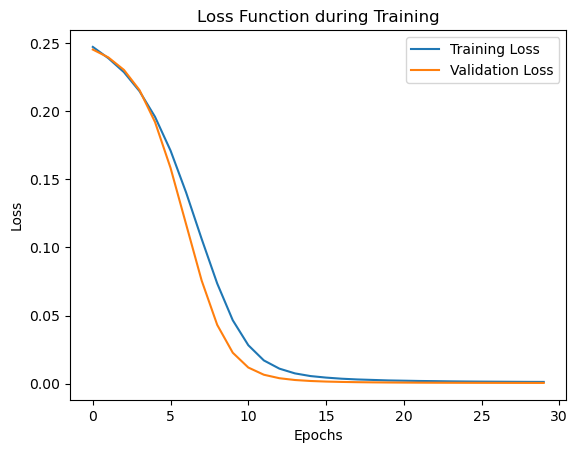

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
Res = sparse_autoencoder(X_train, X_test)
history = Res[4]
# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function during Training')
plt.legend()
plt.show()


In [297]:
X

,489,3412,4010,6006,6017,6153,6185,6606,5978,6422,...,6801,6802,6803,6806,6821,6822,6823,6824,6825,6830
2002-03-06,0.006932,0.008273,0.004998,-0.040340,0.022407,0.282443,0.015157,0.055844,-0.040147,-0.000638,...,0.038855,0.004979,-0.003386,-0.007066,0.030230,-0.027764,-0.029382,0.009958,0.005976,0.004521
2002-03-07,0.008485,-0.012821,0.060707,0.022268,0.027397,0.455357,-0.009954,0.009167,0.068746,0.092516,...,-0.001098,-0.020350,-0.001699,0.025953,0.071353,-0.000985,0.021341,0.023613,-0.009862,0.003809
2002-03-08,0.011442,0.000779,0.044123,0.000222,-0.028003,0.098160,-0.001077,-0.002699,-0.031586,0.003353,...,-0.006625,-0.006983,-0.069221,0.000129,0.023661,0.039921,0.006149,0.093657,0.000000,-0.006642
2002-03-11,0.009043,0.002855,0.005530,-0.013556,0.056245,-0.009311,-0.026959,-0.005737,-0.005333,0.011494,...,-0.000369,-0.001763,0.029835,-0.005824,-0.035733,-0.033649,0.012302,-0.023487,0.004200,0.020647
2002-03-12,-0.001038,0.011646,-0.020631,-0.005181,0.025974,-0.080827,0.038050,-0.010722,-0.010315,-0.026910,...,-0.000369,0.030119,-0.023646,0.001439,0.008681,-0.041687,-0.008276,0.009019,-0.000239,-0.038405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,0.002254,0.003984,0.008145,0.013740,0.018502,0.030590,0.011617,0.004296,-0.030266,0.001995,...,0.011449,0.007766,0.012627,-0.027975,0.001816,0.025259,0.011543,0.029024,0.005581,0.005394
2023-09-15,-0.015444,0.000529,-0.001003,-0.013299,-0.017296,-0.003062,-0.011078,-0.000742,0.014744,-0.001326,...,-0.018352,-0.008188,-0.029646,-0.016934,0.002702,-0.050901,0.004280,-0.009271,-0.026131,-0.012850
2023-09-18,-0.019393,-0.025248,0.002767,-0.003613,-0.000443,-0.013981,-0.003552,0.001490,0.001490,0.001490,...,0.010037,-0.008984,0.009553,0.001472,-0.002217,-0.006975,-0.002417,0.016843,0.006464,0.005570
2023-09-19,0.012051,-0.016816,-0.007950,-0.008534,-0.006534,-0.007531,0.001097,-0.008252,-0.017058,0.001254,...,0.018130,-0.015068,-0.021039,-0.000899,0.004582,-0.007830,-0.013948,-0.007669,0.009919,-0.062576


(21,)


2005-03-30    0.009611
2005-03-31    0.002771
2005-04-01   -0.001418
2005-04-04   -0.001037
2005-04-05    0.006999
                ...   
2005-12-28    0.004018
2005-12-29    0.002594
2005-12-30   -0.000108
2006-01-02    0.000363
2006-01-03    0.012092
Length: 200, dtype: float64

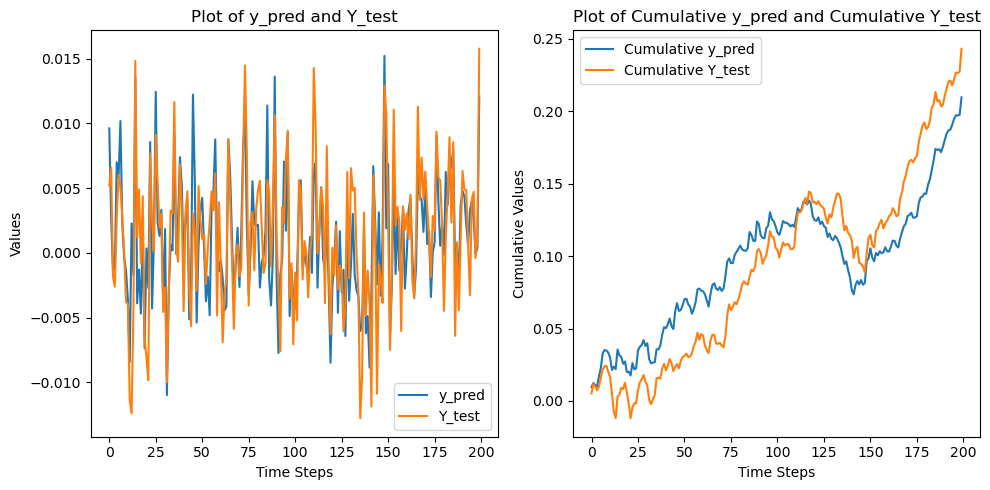

Number of selected features: 20
Tracking Error: 0.003627381847891048


In [13]:
selected_X_test, selected_X_train, _,_, Nb_least_comm_val = Res

results = ols_regression(selected_X_train,Y_train)
coeff = results.params
print(coeff.shape)

#do regression using fitted coefficient to predict y on test set 
predicted_values = results.predict(sm.add_constant(selected_X_test))

display(predicted_values)

# Plot the predicted values and Y_test
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(predicted_values.values, label='y_pred')
plt.plot(Y_test, label='Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Plot of y_pred and Y_test')
plt.legend()

# Compute the cumulative values
cumulative_predicted_values = np.cumsum(predicted_values.values)
cumulative_Y_test = np.cumsum(Y_test)

plt.subplot(1, 2, 2)
plt.plot(cumulative_predicted_values, label='Cumulative y_pred')
plt.plot(cumulative_Y_test, label='Cumulative Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Values')
plt.title('Plot of Cumulative y_pred and Cumulative Y_test')
plt.legend()

plt.tight_layout()
plt.show()

print("Number of selected features:", len(selected_X_test.columns))

tracking_error = np.sqrt(compute_mse(predicted_values, Y_test))
print("Tracking Error:", tracking_error)



random selection process, just to compare 



In [14]:
import random

def random_feature_selection(X, num_features):
    # Get the column names of X
    columns = X.columns.tolist()

    # Select num_features randomly from the columns
    selected_features = random.sample(columns, num_features)

    # Return the selected features
    return X[selected_features]


X_test = X[int(len(X)*0.8):]

num_iterations = 100  # Number of iterations to repeat the code block
tracking_errors = []  # List to store tracking errors

for _ in range(num_iterations):
    # Perform the same task as the previous cell
    selected_X_train_random = random_feature_selection(X_train, len(selected_X_train.columns))
    results = ols_regression(selected_X_train_random, Y_train)

    # Get the predicted values
    predicted_values_random = results.predict(sm.add_constant(X_test[selected_X_train_random.columns]))
    

    tracking_error_random = compute_mse(predicted_values_random, Y_test)
    tracking_errors.append(tracking_error_random)

mean_tracking_error = sum(tracking_errors) / len(tracking_errors)
print("Mean Average Tracking Error for random selection sample:", np.sqrt(mean_tracking_error))


Mean Average Tracking Error for random selection sample: 0.0029718996787733163


In [313]:
X

,489,3412,4010,6006,6017,6153,6185,6606,5978,6422,...,6801,6802,6803,6806,6821,6822,6823,6824,6825,6830
2002-03-06,0.006932,0.008273,0.004998,-0.040340,0.022407,0.282443,0.015157,0.055844,-0.040147,-0.000638,...,0.038855,0.004979,-0.003386,-0.007066,0.030230,-0.027764,-0.029382,0.009958,0.005976,0.004521
2002-03-07,0.008485,-0.012821,0.060707,0.022268,0.027397,0.455357,-0.009954,0.009167,0.068746,0.092516,...,-0.001098,-0.020350,-0.001699,0.025953,0.071353,-0.000985,0.021341,0.023613,-0.009862,0.003809
2002-03-08,0.011442,0.000779,0.044123,0.000222,-0.028003,0.098160,-0.001077,-0.002699,-0.031586,0.003353,...,-0.006625,-0.006983,-0.069221,0.000129,0.023661,0.039921,0.006149,0.093657,0.000000,-0.006642
2002-03-11,0.009043,0.002855,0.005530,-0.013556,0.056245,-0.009311,-0.026959,-0.005737,-0.005333,0.011494,...,-0.000369,-0.001763,0.029835,-0.005824,-0.035733,-0.033649,0.012302,-0.023487,0.004200,0.020647
2002-03-12,-0.001038,0.011646,-0.020631,-0.005181,0.025974,-0.080827,0.038050,-0.010722,-0.010315,-0.026910,...,-0.000369,0.030119,-0.023646,0.001439,0.008681,-0.041687,-0.008276,0.009019,-0.000239,-0.038405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,0.002254,0.003984,0.008145,0.013740,0.018502,0.030590,0.011617,0.004296,-0.030266,0.001995,...,0.011449,0.007766,0.012627,-0.027975,0.001816,0.025259,0.011543,0.029024,0.005581,0.005394
2023-09-15,-0.015444,0.000529,-0.001003,-0.013299,-0.017296,-0.003062,-0.011078,-0.000742,0.014744,-0.001326,...,-0.018352,-0.008188,-0.029646,-0.016934,0.002702,-0.050901,0.004280,-0.009271,-0.026131,-0.012850
2023-09-18,-0.019393,-0.025248,0.002767,-0.003613,-0.000443,-0.013981,-0.003552,0.001490,0.001490,0.001490,...,0.010037,-0.008984,0.009553,0.001472,-0.002217,-0.006975,-0.002417,0.016843,0.006464,0.005570
2023-09-19,0.012051,-0.016816,-0.007950,-0.008534,-0.006534,-0.007531,0.001097,-0.008252,-0.017058,0.001254,...,0.018130,-0.015068,-0.021039,-0.000899,0.004582,-0.007830,-0.013948,-0.007669,0.009919,-0.062576


## With rebalancing every 28 days same rolling window approach as lasso for test/training

Epoch 1/30
3/3 [==============================] - 0s 48ms/step - loss: 0.2524 - val_loss: 0.2518
Epoch 2/30
3/3 [==============================] - 0s 13ms/step - loss: 0.2504 - val_loss: 0.2509
Epoch 3/30
3/3 [==============================] - 0s 11ms/step - loss: 0.2485 - val_loss: 0.2500
Epoch 4/30
3/3 [==============================] - 0s 11ms/step - loss: 0.2466 - val_loss: 0.2489
Epoch 5/30
3/3 [==============================] - 0s 18ms/step - loss: 0.2447 - val_loss: 0.2478
Epoch 6/30
3/3 [==============================] - 0s 25ms/step - loss: 0.2427 - val_loss: 0.2466
Epoch 7/30
3/3 [==============================] - 0s 15ms/step - loss: 0.2406 - val_loss: 0.2452
Epoch 8/30
3/3 [==============================] - 0s 17ms/step - loss: 0.2385 - val_loss: 0.2437
Epoch 9/30
3/3 [==============================] - 0s 14ms/step - loss: 0.2362 - val_loss: 0.2420
Epoch 10/30
3/3 [==============================] - 0s 14ms/step - loss: 0.2339 - val_loss: 0.2402
Epoch 11/30
3/3 [============

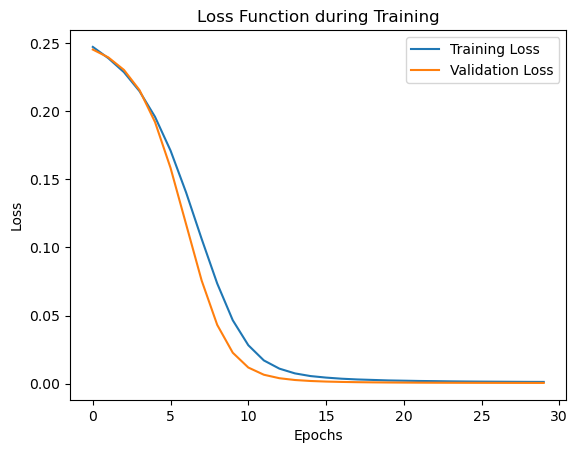

Epoch 1/30
3/3 [==============================] - 0s 61ms/step - loss: 0.2526 - val_loss: 0.2471
Epoch 2/30
3/3 [==============================] - 0s 10ms/step - loss: 0.2504 - val_loss: 0.2462
Epoch 3/30
3/3 [==============================] - 0s 14ms/step - loss: 0.2483 - val_loss: 0.2453
Epoch 4/30
3/3 [==============================] - 0s 11ms/step - loss: 0.2461 - val_loss: 0.2443
Epoch 5/30
3/3 [==============================] - 0s 19ms/step - loss: 0.2440 - val_loss: 0.2431
Epoch 6/30
3/3 [==============================] - 0s 17ms/step - loss: 0.2418 - val_loss: 0.2419
Epoch 7/30
3/3 [==============================] - 0s 16ms/step - loss: 0.2396 - val_loss: 0.2405
Epoch 8/30
3/3 [==============================] - 0s 25ms/step - loss: 0.2373 - val_loss: 0.2390
Epoch 9/30
3/3 [==============================] - 0s 25ms/step - loss: 0.2348 - val_loss: 0.2374
Epoch 10/30
3/3 [==============================] - 0s 22ms/step - loss: 0.2322 - val_loss: 0.2356
Epoch 11/30
3/3 [============

In [61]:
Y_pred_final_LS = []
rebalance = 28
split_index = 28*5

for i in range(0, X.shape[0]-split_index, rebalance):
    # split_index_here = int(0.8 * len(X.T) + i)  # Use 80% of the data for training
    split_index_here = 5*28 + i

    X_train, Y_train = X[(split_index_here - 5 * 28):split_index_here], Y[(split_index_here - 5 * 28):split_index_here]

    # For testing, take only 28 after split_index_here
    X_test, Y_test = X[split_index_here:(split_index_here + 28)], Y[split_index_here:(split_index_here + 28)]

    Res = sparse_autoencoder(X_train, X_test)

    if i == 0:
        # Plot the loss function
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Function during Training')
        plt.legend()
        plt.show()
    
    selected_X_test, selected_X_train, _,_, Nb_least_comm_val = Res

    results = ols_regression(selected_X_train,Y_train)
    coeff = results.params

    #do regression using fitted coefficient to predict y on test set 
    predicted_values = results.predict(sm.add_constant(selected_X_test))
    
    Y_pred_final_LS.extend(predicted_values.values)


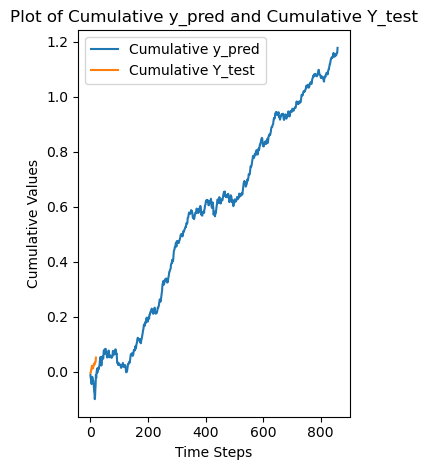

Number of selected features: 20


ValueError: operands could not be broadcast together with shapes (20,) (1000,) 

In [64]:
Y_pred_final_LS
# Compute the cumulative values
cumulative_predicted_values = np.cumsum(Y_pred_final_LS)
cumulative_Y_test = np.cumsum(Y_test)

plt.subplot(1, 2, 2)
plt.plot(cumulative_predicted_values, label='Cumulative y_pred')
plt.plot(cumulative_Y_test, label='Cumulative Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Values')
plt.title('Plot of Cumulative y_pred and Cumulative Y_test')
plt.legend()

plt.tight_layout()
plt.show()

print("Number of selected features:", len(selected_X_test.columns))

tracking_error = np.sqrt(compute_mse(predicted_values, Y))
print("Tracking Error:", tracking_error)

In [43]:
type(predicted_values)

pandas.core.series.Series

In [34]:
Y_pred_final_LS[]

[2002-09-18   -0.008015
 2002-09-19   -0.007428
 2002-09-20    0.002809
 2002-09-23   -0.014900
 2002-09-24   -0.004887
 2002-09-25    0.004781
 2002-09-26    0.014523
 2002-09-27   -0.005127
 2002-09-30   -0.004509
 2002-10-01   -0.004932
 2002-10-02   -0.008443
 2002-10-03   -0.011527
 2002-10-04   -0.010362
 2002-10-07   -0.006976
 2002-10-08   -0.010079
 2002-10-09   -0.021381
 2002-10-10   -0.004145
 2002-10-11    0.027097
 2002-10-14   -0.003742
 2002-10-15    0.041428
 2002-10-16   -0.008236
 2002-10-17    0.014368
 2002-10-18    0.002044
 2002-10-21    0.006886
 2002-10-22   -0.003355
 2002-10-23    0.012372
 2002-10-24   -0.004360
 2002-10-25    0.012497
 dtype: float64,
 2002-10-28    0.002619
 2002-10-29   -0.006008
 2002-10-30    0.016370
 2002-10-31    0.005921
 2002-11-01    0.012221
 2002-11-04    0.003198
 2002-11-05    0.000276
 2002-11-06    0.014857
 2002-11-07   -0.007378
 2002-11-08    0.000243
 2002-11-11   -0.014964
 2002-11-12    0.008071
 2002-11-13    0.003422

In [33]:
Y_pred_final_LS_array = np.array(Y_pred_final_LS) 
Y_pred_final_LS_array

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (31,) + inhomogeneous part.

In [23]:
# Compute the cumulative values
cumulative_predicted_values = np.cumsum(Y_pred_final_LS)
cumulative_Y_test = np.cumsum(Y_test)

plt.subplot(1, 2, 2)
plt.plot(cumulative_predicted_values, label='Cumulative y_pred')
plt.plot(cumulative_Y_test, label='Cumulative Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Values')
plt.title('Plot of Cumulative y_pred and Cumulative Y_test')
plt.legend()

plt.tight_layout()
plt.show()

print("Number of selected features:", len(selected_X_test.columns))

tracking_error = np.sqrt(compute_mse(predicted_values, Y_test))
print("Tracking Error:", tracking_error)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (31,) + inhomogeneous part.

In [308]:
Y

,0
0,0.005207
1,0.014811
2,0.002839
3,-0.001681
4,-0.007410
...,...
5616,0.006809
5617,-0.007020
5618,-0.003090
5619,-0.005468
